In [2]:
from scipy import stats
import numpy as np
from timeit import default_timer as time
import matplotlib.pyplot as plt

$7.16)$  We use importante sampling, drawing from $Beta(a, b)$ for various values of a and b, to estimate the integral $$\int_0^\pi \frac{dx}{x^3 + 2x + 3}$$

Let $f(x) = \frac{1}{x^3 + 2x + 3}$. Observe that 
$\int_0^\pi f(x) dx = \int_0^1 f(\pi x) |det(\pi)|dx = \pi \int_0^1 f(\pi x) dx$

Below we see that our estimate is $\sim0.4025$

In [21]:
# define the function
f = lambda x: (x**3 + 2*x + 3)**-1

# take n draws from the Beta(a, b)
a = 1
b = 1
n = 1_000_000
beta = stats.beta(a, b)
samples = beta.rvs(n)

# take MC expected value
x = f(np.pi * samples) / beta.pdf(samples)
x.mean() * np.pi

0.40213321371336674

$7.18)$ 

$i)$ Let $U \sim Uniform(0, 1)$ and $Y = G(U)$ where $G(u) = \text{min}\{ a \in A : u \leq F_X(a) \}$. 

We show that $F_Y = F_X$. 

Since $A$ is discrete, $A = \{a_1, a_2, ..., a_n\}$ with $a_1 < a_2 < ... < a_n$.

We say that $F_X(x) = P(X \leq x) = \sum_{j \leq i} P(a_j)$ where $a_i = max\{a \in A : a \leq x\}$.

Consider $F_Y(y) 
\\ = P(Y \leq y)
\\ = P(G(U) \leq y)
\\ = P\{ \{ \inf \{ a \in A : u \leq F_X(a) \} : u \in U \text{ and } u \leq y \}
\\ = P\{ a \in A : u \leq F_X(a) \} \leq y \} \text{   Note, that this set is mutually exclusive} 
\\ = \sum_{j \leq i} P(a_j) = F_X(x)$

In [91]:
def discrete_inversion_sampling(cdf, support: list, n=1_000):
    """
    Sample from any discrete distribution using inversion sampling
    
    Args:
        cdf      (function): cmf of the distribution
        support  (iterable): list of values--support of the cmf
    """
    
    support = np.array(support)
    
    # take n draws from Uniform(0, 1)
    U = stats.uniform(0, 1).rvs(n)
    
    # create inverse sampling function
    def Y(u):
        F_X = cdf(support)
        mask = (u <= F_X)
        index = np.argmin(F_X[mask]) 
        return support[mask][index]
    Y = np.vectorize(Y)
    
    return Y(U)

$ii)$ Use the above arbitrary discrete inversion sampler to sample from a $Bernoulli(p)$ distribution for arbitrary p. We sample $1000$ times and average the results.

In [93]:
bernoulli_cdf = stats.binom(n=1, p=.8).cdf
support = [0, 1]

discrete_inversion_sampling(cdf, support).mean()

0.801

$iii)$ We now sample from a $Binomial(n, p)$ distribution. We can do this for arbitrary $n$ and $p$. 

In [95]:
binom_cdf = stats.binom(n=100, p=0.8).cdf
support = np.arange(n + 1)

discrete_inversion_sampling(binom_cdf, support).mean()

79.861

We can also approximate this by summing $n$ draws from a $Bernoulli(p)$ distribution and summing them.

In [108]:
bernoulli_cdf = stats.binom(n=1, p=.8).cdf
support = [0, 1]

discrete_inversion_sampling(bernoulli_cdf, support, n=100).sum()

79

The results of these methods are generally pretty similar. I will time them to compare speeds.

Seconds to sample from Binomial distribution: 0.11253896000016539


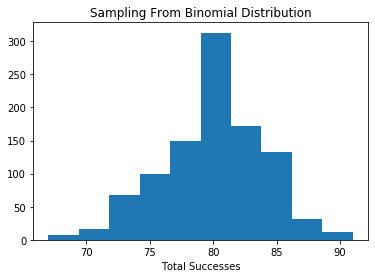

Seconds to sample from a Bernoulli distribution and sum 7.380480607998834


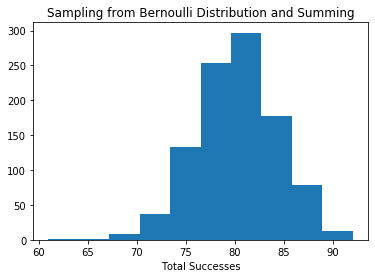

In [116]:
# time binomial
start = time()
support = np.arange(100)
samples = discrete_inversion_sampling(binom_cdf, support)
print('Seconds to sample from Binomial distribution:', time() - start)
plt.hist(samples)
plt.title("Sampling From Binomial Distribution")
plt.xlabel("Total Successes")
plt.show()

# sample from bernoulli
start = time()
support = [0, 1]
samples = [
    discrete_inversion_sampling(bernoulli_cdf, support, n=100).sum()
    for _ in range(1000)
]
print('Seconds to sample from a Bernoulli distribution and sum', time() - start)
plt.hist(samples)
plt.title("Sampling from Bernoulli Distribution and Summing")
plt.xlabel("Total Successes")
plt.show()


$iii)$

We now sample $1000$ draws from from $NegBin(k=5, p=0.4)$. Then we plot a histogram of the true distribution and compare the results.

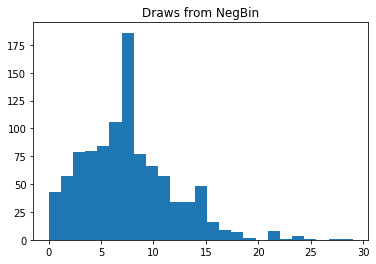

In [137]:
# probability of getting n (our k) successes before n failures with probability p of success
neg_bin_cdf = stats.nbinom(n=5, p=0.4).cdf

# the support is infinite, so we use [0, 999] x Z as an approximation
support = np.arange(100) 

# take 1,000 draws from the NegBin(5, 0.4) distribution
draws = discrete_inversion_sampling(neg_bin_cdf, support, n=1000)

# plot histogram of our draws
plt.hist(draws, bins=25)
plt.title("Draws from NegBin")
plt.show()

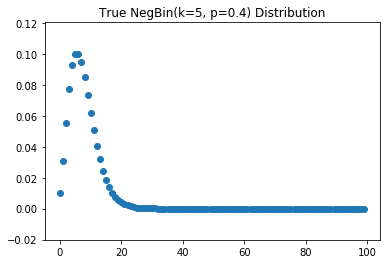

In [147]:
# plot histogram of true distribution
pdf = stats.nbinom(n=5, p=0.4).pmf
plt.scatter(support, pdf(support))
plt.title("True NegBin(k=5, p=0.4) Distribution")
plt.show()

$7.19)$

We will use rejection sampling to sample $1,000$ times from the pdf $f(x) \propto x(1 - x)e^x$ on $[0, 1]$. The correct answer is $0.28172$.

0.15795

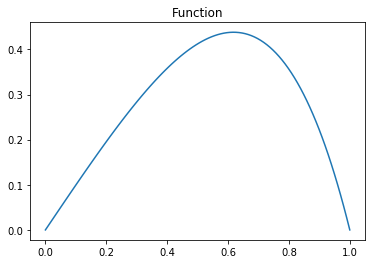

In [3]:
# define the function
f = lambda x: x * (1 - x) * np.exp(x)

# find the min and max values on [0, 1]
domain = np.linspace(0, 1, 100)
values = f(domain)
plt.plot(domain, values)
plt.title('Function')

# take draws from the box [0, 1] x [0, .5]
n = 1000
height = 0.45
x = stats.uniform(0, 1).rvs(n)
y = stats.uniform(0, height).rvs(n)

# enter x values into function
samples = f(x)

# determine proportion that are in the 2d box
percent = (samples < y).mean()

# estimate the area under the curve
area_of_box = 1 * height
estimated_integral = area_of_box * percent
estimated_integral

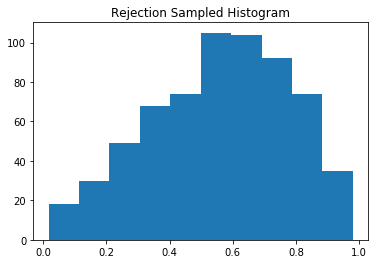

In [7]:
plt.hist(x[samples > y])
plt.title('Rejection Sampled Histogram')
plt.show()